<a href="https://colab.research.google.com/github/Diego-Hernandez-Jimenez/prototype_learning_LVQ/blob/main/LVQ_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prototype-based learning. Part II: LVQ family of models in Pytorch

This notebook is a continuation of Prototype-based learning. Part I: GMLVQ from scratch. Here all Pytorch features are used to create a more complete model of LVQ. Final implementation allows to:

* use different versions of the LVQ model and of the loss function
* choose among different gradient-based optimization algorithms
* use stochastic or batch gradient descent

In [ ]:
from time import time

import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, load_iris, load_digits
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neural_network import MLPClassifier

## Main class and initialization methods

In [ ]:
class LVQ(nn.Module):
  """
    A class representing a Learning Vector Quantization (LVQ) model with various modes (GLVQ, GMLVQ, GRLVQ, LGMLVQ, etc.).
    The class supports different prototype initialization strategies and relevance matrices for generalized and local LVQ variants.

    Args:
        lvq_mode (str): The LVQ mode to use. Supported modes include:
        - 'glvq': Generalized LVQ.
        - 'gmlvq': Generalized Matrix LVQ.
        - 'grlvq': Generalized Relevance LVQ.
        - 'lgmlvq': Local Generalized Matrix LVQ.
        - 'lgrlvq': Local Generalized Relevance LVQ.

        data (torch.utils.data.TensorDataset): The dataset used for training, containing feature vectors and class labels.

        n_prototypes_per_class (list): A list where each element indicates the number of prototypes assigned to each class.

        naive_init (bool, optional): Whether to initialize the prototypes randomly (`True`) or based on class averages (`False`).
        Default is `False`.

       Q_rank (int, optional): The rank of the relevance matrix (Q) for local relevance LVQ variants. Default is `None`.

    Attributes:
        W (nn.ParameterList): The list of prototype tensors.
        prototype_labels (torch.Tensor): The class labels associated with each prototype.
        Q (nn.Parameter or nn.ParameterList): The relevance matrix/matrices used to compute distances between inputs and prototypes.
        distance_to_prototypes (callable): The distance function to compute distances between inputs and prototypes.
    """

  def __init__(self, lvq_mode, data, n_prototypes_per_class, naive_init=False, Q_rank=None):
    super(LVQ, self).__init__()
    self.lvq_mode = lvq_mode
    self.n_features = data.tensors[0].shape[1]
    self.n_prototypes = sum(n_prototypes_per_class)
    self.n_prototypes_per_class = n_prototypes_per_class
    self.W, self.prototype_labels = self.init_prototypes(data, naive_init)
    self.Q = self.init_pseudorelevance_matrix(Q_rank)
    self.distance_to_prototypes = self.choose_dist_function()

  def init_prototypes(self, data, naive_init):
    """
    Initializes the prototype vectors. Prototypes can be initialized either randomly (naive) or
    by averaging subsets of data points for each class.

    Args:
        data (torch.utils.data.TensorDataset): The dataset containing feature vectors and class labels.

        naive_init (bool): If `True`, prototypes are initialized randomly around the global average of the dataset.
        If `False`, they are initialized as class averages.

    Returns:
        nn.ParameterList: A list of initialized prototype vectors as parameters.
        torch.Tensor: A tensor containing the class labels associated with each prototype.
    """

    X, y = data.tensors
    W = []
    Wclasses = [[class_id] * times_each_proto for class_id, times_each_proto in enumerate(self.n_prototypes_per_class)]
    Wclasses = sum(Wclasses, []) # flattens nested list
    if naive_init:
      global_avg = X.mean(dim=0)
      W = [global_avg + torch.randn_like(global_avg) for _ in range(self.n_prototypes)]
    else:
      for class_id, times_each_proto in enumerate(self.n_prototypes_per_class):
        # get prototypes as avg of class
        for _ in range(times_each_proto):
          ids = torch.nonzero(y == class_id).squeeze()
          subset_size = (1/times_each_proto) * len(ids)
          subset_ids = ids[torch.randperm(len(ids))[:int(subset_size)]]
          w = X[subset_ids].mean(dim=0)
          W.append(w)

    return nn.ParameterList(W), torch.tensor(Wclasses).to(device)

  def init_pseudorelevance_matrix(self, Q_rank):
    """
    Initializes the (pseudo)relevance matrix (Q) based on the LVQ mode. In 'gmlvq' and 'grlvq', a global matrix is used, while
    in 'lgmlvq' and 'lgrlvq', local relevance matrices are used for each prototype.

    Returns:
        nn.Parameter or nn.ParameterList: The relevance matrix/matrices depending on the LVQ mode.
    """
    if Q_rank is None:
      Q_rank = self.n_features

    if self.lvq_mode == 'glvq':
      # Q = torch.sqrt(torch.eye(self.n_features))
      Q = torch.eye(self.n_features)

    elif self.lvq_mode == 'grlvq':
      Q = torch.sqrt(torch.eye(self.n_features))
      Q = nn.Parameter(Q)

    elif self.lvq_mode == 'gmlvq':
      Q = torch.randn((self.n_features, Q_rank))
      Q = Q / torch.sqrt((Q @ Q.T).diag().sum())
      Q = nn.Parameter(Q)

    elif self.lvq_mode == 'lgrlvq':
      Q = [torch.sqrt(torch.eye(self.n_features)) for _ in range(self.n_prototypes)]
      Q = nn.ParameterList(Q)

    elif self.lvq_mode == 'lgmlvq':
      Q = torch.randn((self.n_features, Q_rank))
      Q = [Q / torch.sqrt((Q @ Q.T).diag().sum()) for _ in range(self.n_prototypes)]
      Q = nn.ParameterList(Q)




    else:
      print('choose appropiate lvq model')
      return None

    return Q

  def choose_dist_function(self):
    """
    Selects the distance function based on the LVQ mode. The function computes the distance between input
    vectors and the prototypes, using either a global or local relevance matrix.

    Returns:
        callable: A function to compute the distances between input vectors and prototypes.
    """

    dists = []
    if self.lvq_mode == 'glvq':
      def distance_to_prototypes(x):
        dists = []
        for j in range(self.n_prototypes):
          raw_diff = x - self.W[j]
          d = torch.linalg.vector_norm(raw_diff, ord=2, dim=1, keepdim=True)**2
          dists.append(d)
        return torch.cat(dists, dim=1)

    elif self.lvq_mode == 'gmlvq' or self.lvq_mode == 'grlvq':
      def distance_to_prototypes(x):
        dists = []
        for j in range(self.n_prototypes):
          raw_diff = x - self.W[j]
          d = torch.linalg.vector_norm(raw_diff @ self.Q, ord=2, dim=1, keepdim=True)**2
          # d = torch.linalg.multi_dot([raw_diff, self.Q.t(), self.Q, raw_diff.t()])
          dists.append(d)
        return torch.cat(dists, dim=1)

    elif self.lvq_mode == 'lgrlvq' or self.lvq_mode == 'lgmlvq':
      def distance_to_prototypes(x):
        dists = []
        for j in range(self.n_prototypes):
          raw_diff = x - self.W[j]
          d = torch.linalg.vector_norm(raw_diff @ self.Q[j], ord=2, dim=1, keepdim=True)**2
          # d = torch.linalg.multi_dot([raw_diff, self.Q[j].t(), self.Q[j], raw_diff.t()])
          dists.append(d)
        return torch.cat(dists, dim=1)
    else:
      print('choose appropiate lvq model')

    return distance_to_prototypes

  def forward(self, x):
    """
     Forward pass for the LVQ model. Computes the distances between the input samples and the prototypes.

     Args:
         x (torch.Tensor): The input data, a tensor of shape (n_samples, n_features).

     Returns:
         torch.Tensor: A tensor containing the distances between each input sample and the prototypes.
    """

    dists = self.distance_to_prototypes(x)
    return dists

## Loss functions and training procedure

In [ ]:
class GLVQLoss(nn.Module):
  """
  Generalized Learning Vector Quantization (GLVQ) loss function, also known as the relative distance loss.
  The loss encourages the distance between input data and correct prototypes (d_pos) to be minimized while
  maximizing the distance to incorrect prototypes (d_neg), using a specified activation function.

  Args:
      activation (torch.nn.Module): The activation function to apply to the computed loss. Common choices are:
      - `torch.nn.Identity()` for linear behavior.
      - `torch.nn.Sigmoid()` for a squashing effect on the relative distances.

  Example:
      >>> loss_fn = GLVQLoss(activation=torch.nn.Sigmoid())
      >>> d_pos = torch.tensor([0.5, 0.2])
      >>> d_neg = torch.tensor([1.0, 0.8])
      >>> loss = loss_fn(d_pos, d_neg)
      >>> print(loss)
  """

  def __init__(self, activation):
    super(GLVQLoss, self).__init__()
    self.activation = activation

  def forward(self, d_pos, d_neg):
    return self.activation((d_pos - d_neg) / (d_pos + d_neg)).mean()

# Other possible loss functions (based on LeCun et al. (2006), hence assuming our LVQ is an energy based model)
# In practice I've notice some weird behavior

class LogLoss(nn.Module):
  def __init__(self):
    super(LogLoss, self).__init__()

  def forward(self, d_pos, d_neg):
    return torch.log(1 + torch.exp(d_pos - d_neg)).mean()

class SquareSquareLoss(nn.Module):
  def __init__(self):
    super(SquareSquareLoss, self).__init__()

  def forward(self, d_pos, d_neg):
    return ( d_pos**2 + torch.relu(1 - d_neg) ).mean()

class SquareExponentialLoss(nn.Module):
  def __init__(self, tau):
    super(SquareExponentialLoss, self).__init__()
    self.tau = tau

  def forward(self, d_pos, d_neg):
    return ( d_pos**2 + self.tau * torch.exp(-d_neg) ).mean()

class HingeLoss(nn.Module):
  def __init__(self):
    super(HingeLoss, self).__init__()

  def forward(self, d_pos, d_neg):
    return torch.relu(1 + d_pos - d_neg).mean()

In [ ]:
def train_lvq(model, data_loader, epochs, loss_function, optimizer, scheduler=None, verbose=True):
  """
  Trains a Learning Vector Quantization (LVQ) model over a specified number of epochs using the provided
  data, loss function, and optimization strategy.

  Args:
      model (LVQ): An instance of the LVQ model that is being trained. The model contains prototypes,
      relevance matrices (Q), and the mode of training (e.g., 'gmlvq', 'lgmlvq', etc.).

      data_loader (torch.utils.data.DataLoader): A DataLoader object providing mini-batches of data (features `x`
      and labels `lab`) during training.

      epochs (int): The number of epochs to train the model for.

      loss_function (torch.nn.Module): The loss function to be used during training. Typically, this would be an instance
      of `GLVQLoss`, which computes the relative distance loss.

      optimizer (torch.optim.Optimizer): The optimizer responsible for updating the model parameters (prototypes and
      relevance matrices) based on the computed gradients.

      scheduler (torch.optim.lr_scheduler, optional): A learning rate scheduler that adjusts the learning rate during
      training, if provided. Defaults to `None`.

      verbose (bool, optional): Whether to print loss information after each epoch. If `True`, prints the average loss for each epoch.
      Defaults to `True`.

  Returns:
      None: The function updates the model parameters in place and prints loss information during training.

  Training Procedure:
      - For each mini-batch of data:
          1. Compute the distances between the input samples and the prototypes using the model.
          2. Identify the closest correct prototype (`d_pos`) and the closest incorrect prototype (`d_neg`) for each sample.
          3. Compute the loss using the provided `loss_function` (e.g., GLVQ loss).
          4. Perform backpropagation to compute the gradients.
          5. Update the model parameters (prototypes and relevance matrices) using the `optimizer`.
          6. If a `scheduler` is provided, adjust the learning rate after each step.
          7. Normalize the relevance matrices (`Q`) after each update to maintain their constraints.
      - After each epoch, print the average loss if `verbose` is set to `True`.

  Example:
      >>> model = LVQ('gmlvq', data, n_prototypes_per_class)
      >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
      >>> loss_fn = GLVQLoss(torch.nn.Identity())
      >>> train_lvq(model, data_loader, epochs=100, loss_function=loss_fn, optimizer=optimizer)

  Notes:
      - Different normalization steps are applied to the relevance matrix `Q` depending on the chosen LVQ mode:
          - 'gmlvq' and 'grlvq': Normalizes `Q` globally.
          - 'lgmlvq' and 'lgrlvq': Normalizes each relevance matrix individually.
  """

  model.train()
  for epoch in range(epochs):
    total_loss = 0.0
    for x, lab in data_loader:
      x, lab = x.to(device), lab#.to(device)
      optimizer.zero_grad()

      dists = model(x)
      d_pos = torch.stack([torch.min(dists[i, model.prototype_labels == lab[i]]) for i in range(len(lab))])
      d_neg = torch.stack([torch.min(dists[i, model.prototype_labels != lab[i]]) for i in range(len(lab))])

      loss = loss_function(d_pos, d_neg)
      total_loss += loss.item()
      loss.backward()
      optimizer.step()
      if scheduler is not None:
        scheduler.step()

      with torch.no_grad():
        if model.lvq_mode == 'gmlvq':
          model.Q.data = model.Q / torch.sqrt((model.Q @ model.Q.T).diag().sum())

        elif model.lvq_mode == 'grlvq':
          model.Q.data = torch.diag(torch.diag(model.Q.data))
          model.Q.data = model.Q / torch.sqrt((model.Q @ model.Q.T).diag().sum())

        elif model.lvq_mode == 'lgrlvq':
          for j in range(len(model.Q)):
            model.Q[j].data = torch.diag(torch.diag(model.Q[j].data))
            model.Q[j].data = model.Q[j] / torch.sqrt((model.Q[j] @ model.Q[j].T).diag().sum())

        elif model.lvq_mode == 'lgmlvq':
          for j in range(len(model.Q)):
            model.Q[j].data = model.Q[j] / torch.sqrt((model.Q[j] @ model.Q[j].T).diag().sum())

        else:
          pass

    if verbose:
      print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(data_loader)}")

  return None

def predict_class(X, model):
  """
  Predicts the class labels for a set of input samples based on the nearest prototype
  in the provided LVQ model.

  Args:
      X (torch.Tensor): A tensor of shape (n_samples, n_features) containing the input data for which
      class predictions are required.

      model (LVQ): An instance of the trained LVQ model, containing the learned prototypes and relevance
      matrices. The model is used to compute the distances between the input samples and the prototypes.

  Returns:
      torch.Tensor: A tensor of shape (n_samples,) containing the predicted class labels for each input sample.
      The predicted label corresponds to the class of the prototype closest to each sample.

  Example:
      >>> X_test = torch.randn(100, n_features)
      >>> model = trained_lvq_model
      >>> preds = predict_class(X_test, model)

  Notes:
      - The function operates in evaluation mode, ensuring that gradients are not computed (via `torch.no_grad()`).
      - For each input sample, it computes the distances to all prototypes using the LVQ model, and selects
        the class label of the closest prototype.
  """

  preds = torch.zeros(X.shape[0])
  with torch.no_grad():
    for i in range(X.shape[0]):
      x = X[i].unsqueeze(0)
      d = model(x)
      preds[i] = model.prototype_labels[torch.argmin(d)]

  return preds


def lvq_accuracy(lvq_model, Xtest, ytest):
  preds = predict_class(Xtest, lvq_model)
  acc = (ytest == preds).float().mean()
  print(f'Accuracy: {acc:.4f}')

  return acc

## Test 1: replicating [Schneider et al. (2009)](https://www.cs.rug.nl/~biehl/Preprints/gmlvq.pdf)

If we've implemented the model correctly, we would be able to reproduce the results we obtained in the first notebook. But not only that, our PyTorch module is more flexible now and we are theoretically capable of replicating concerning the results of every LVQ model compared in the paper.

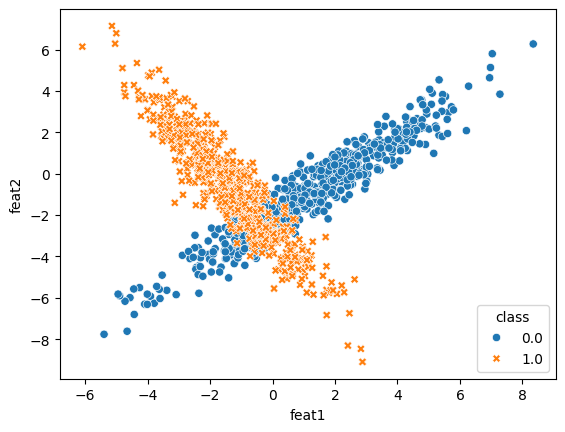

In [ ]:
def create_artificial_data(n:int, seed:int) -> tuple:
  """
  The dataset consists of two clusters of data points,
    each generated from a different multivariate normal distribution with specific
    means, covariance matrices, and rotations (inspired by Schneider et al., 2009).

    Args:
        n (int): Number of samples to generate for each cluster.
        seed (int): Random seed for reproducibility.

    Returns:
        tuple: A tuple containing:
            - data (torch.utils.data.TensorDataset): A PyTorch TensorDataset containing
              the features and labels.
            - df (pandas.DataFrame): A pandas DataFrame containing the features and labels,
              where 'feat1' and 'feat2' are the feature columns and 'class' is the label column.

    Details:
        - Two clusters are generated from multivariate normal distributions with means
          [1.5, 0.0] and [-1.5, 0.0], and covariance matrices with diagonal values
          [0.5^2, 3.0^2].
        - The first cluster is rotated by pi/4 radians, and the second cluster by -pi/6 radians.
        - The final dataset is a combination of both clusters, with labels 0 for the first
          cluster and 1 for the second.

    Example:
        data, df = create_artificial_data(n=100, seed=42)
  """

  torch.manual_seed(seed)
  MV0 = torch.distributions.MultivariateNormal(
      loc=torch.tensor([1.5, 0.0]),
      covariance_matrix=torch.diag(torch.tensor([0.5, 3.0])).pow(2) # [0.1,3.0] [0.5,3.0]
  )
  MV1 = torch.distributions.MultivariateNormal(
      loc=torch.tensor([-1.5, 0.0]), # [-0.8,0.0]
      covariance_matrix=torch.diag(torch.tensor([0.5, 3.0])).pow(2) # [0.1,3.0] [0.5,3.0]
  )
  cluster0 = MV0.sample((1, n)).squeeze(0)
  cluster1 = MV1.sample((1, n)).squeeze(0)

  phi = torch.tensor([torch.pi/4, -torch.pi/6])
  rot_matrix0 = torch.tensor(
      [[torch.cos(phi[0]), -torch.sin(phi[0])],
      [torch.sin(phi[0]), torch.cos(phi[0])]]
  )
  rot_matrix1 = torch.tensor(
      [[torch.cos(phi[1]), -torch.sin(phi[1])],
      [torch.sin(phi[1]), torch.cos(phi[1])]]
  )
  X0 = torch.matmul(cluster0, rot_matrix0)
  X1 = torch.matmul(cluster1, rot_matrix1)
  X = torch.cat([X0, X1], dim=0)
  y = torch.cat([torch.zeros(n), torch.ones(n)])

  # tensor dataset
  data = torch.utils.data.TensorDataset(X, y)

  # pandas dataframe
  df = pd.DataFrame(X, columns=['feat1', 'feat2'])
  df['class'] = y

  return data, df

n = 600
data, df = create_artificial_data(n, seed=42)
p = sns.scatterplot(data=df, x="feat1", y="feat2", hue="class", style="class")

In [ ]:
# small batch size seems to always work better (not only in this first example)
dl = DataLoader(data, batch_size=5, shuffle=True)

# technically, the module allows the use of GPU, but I believe the type of
# some of operations involved (e.g. argmins) pervents us from increasing performance

device = 'cpu'

loss_function = GLVQLoss(nn.Identity())

########################################## Generalized LVQ (new!)
model_glvq = LVQ('glvq', data, [1, 1])
optim_glvq = torch.optim.SGD(model_glvq.W, lr=0.01)
train_lvq(model_glvq, dl, 10, loss_function, optim_glvq, scheduler=None, verbose=False)
##########################################

########################################## Generalized LVQ with 2 prototypes (new!)
model_glvq2 = LVQ('glvq', data, [2, 2])
optim_glvq2 = torch.optim.SGD(model_glvq.W, lr=0.01)
train_lvq(model_glvq2, dl, 10, loss_function, optim_glvq2, scheduler=None, verbose=False)
##########################################


########################################## Generalized Relevance LVQ (new!)
model_grlvq = LVQ('grlvq', data, [1, 1])
optim_grlvq = torch.optim.SGD([
      {'params': model_grlvq.W, 'lr': 0.01},
      {'params': model_grlvq.Q, 'lr': 0.01}
])
train_lvq(model_grlvq, dl, 10, loss_function, optim_grlvq, scheduler=None, verbose=False)
##########################################


######################################### Generalized Matrix LVQ
model_gmlvq = LVQ('gmlvq', data, [1, 1])
optim_gmlvq = torch.optim.SGD([
      {'params': model_gmlvq.W, 'lr': 0.01},
      {'params': model_gmlvq.Q, 'lr': 0.01}
])
train_lvq(model_gmlvq, dl, 10, loss_function, optim_gmlvq, scheduler=None, verbose=False)
##########################################


########################################## Localized Generalized Relevance LVQ (new!)
model_lgrlvq = LVQ('lgrlvq', data, [1, 1])
optim_lgrlvq = torch.optim.SGD([
      {'params': model_lgrlvq.W, 'lr': 0.01},
      {'params': model_lgrlvq.Q, 'lr': 0.01}
])
train_lvq(model_lgrlvq, dl, 10, loss_function, optim_lgrlvq, scheduler=None, verbose=False)
##########################################


########################################## Localized Generalized Matrix LVQ
model_lgmlvq = LVQ('lgmlvq', data, [1, 1])
optim_lgmlvq = torch.optim.SGD([
      {'params': model_lgmlvq.W, 'lr': 0.01},
      {'params': model_lgmlvq.Q, 'lr': 0.01}
])
train_lvq(model_lgmlvq, dl, 10, loss_function, optim_lgmlvq, scheduler=None, verbose=False)
##########################################


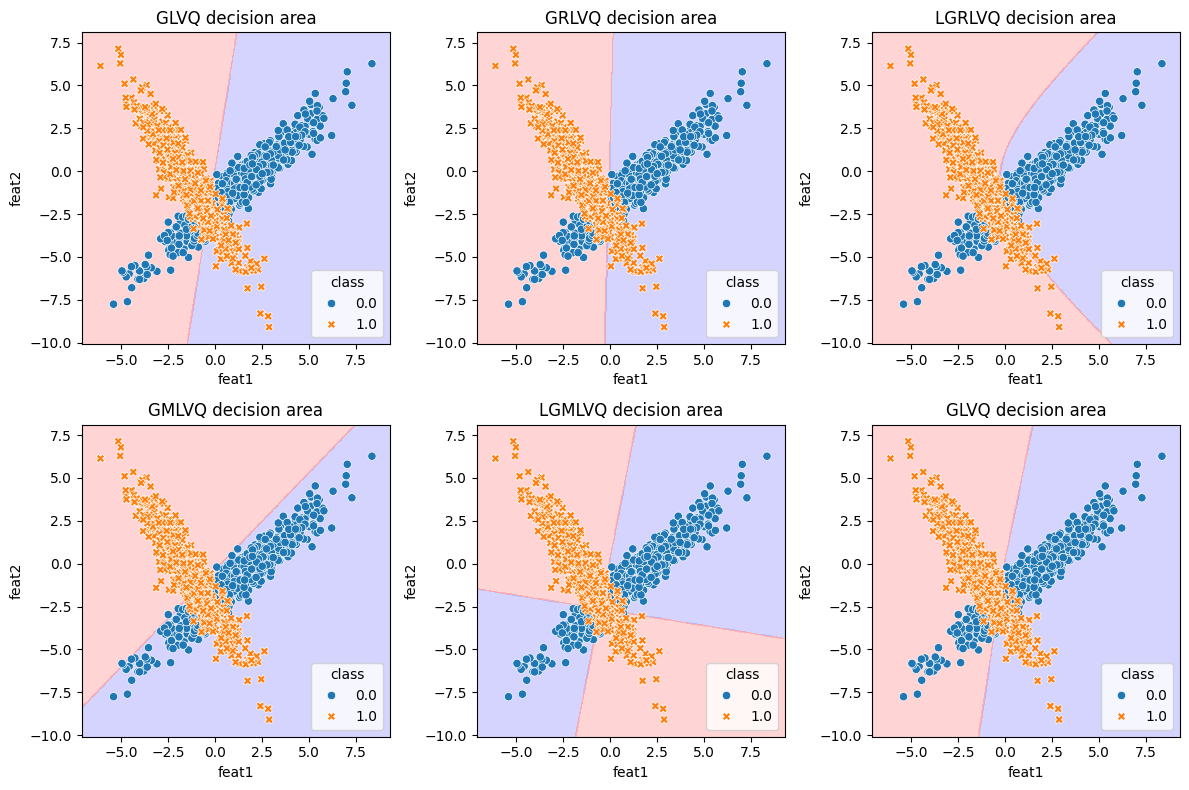

In [ ]:
def data_for_decision_area(model, df):
    """
    Generates grid data for visualizing the decision boundaries of an LVQ model.

    Args:
        model (LVQ): Trained LVQ model used to predict class labels on the grid.
        df (pd.DataFrame): DataFrame containing the features 'feat1' and 'feat2' for plotting the feature space.

    Returns:
        tuple: xx, yy meshgrid tensors and Z tensor of predicted class labels for each grid point.

    Example:
        >>> xx, yy, Z = data_for_decision_area(trained_model, df)
    """
    # Define plot boundaries
    x_min, x_max = df['feat1'].min() - 1, df['feat1'].max() + 1
    y_min, y_max = df['feat2'].min() - 1, df['feat2'].max() + 1

    # Generate grid of points with indexing="xy" to avoid the warning
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, 0.05),
                            torch.arange(y_min, y_max, 0.05), indexing="xy")

    # Prepare grid tensor and predict class for each point
    grid_tensor = torch.stack([xx.flatten(), yy.flatten()], dim=1)
    predicted_classes = predict_class(grid_tensor, model)

    # Reshape predictions for plotting
    Z = predicted_classes.reshape(xx.shape)

    return xx, yy, Z



# Model list to iterate
models = [model_glvq, model_grlvq, model_lgrlvq, model_gmlvq, model_lgmlvq, model_glvq2]

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# Iterate over models and create plots
for i, model in enumerate(models):
    xx, yy, Z = data_for_decision_area(model, df)
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.contourf(xx, yy, Z, alpha=0.5, cmap=ListedColormap(['#AAAAFF', '#FFAAAA']))
    sns.scatterplot(data=df, x='feat1', y='feat2', hue='class', style='class', ax=ax)
    ax.set_xlabel('feat1')
    ax.set_ylabel('feat2')
    ax.set_title(f'{model.lvq_mode.upper()} decision area')

# fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.savefig('all_models_decision_area.png', dpi=300)
plt.show()

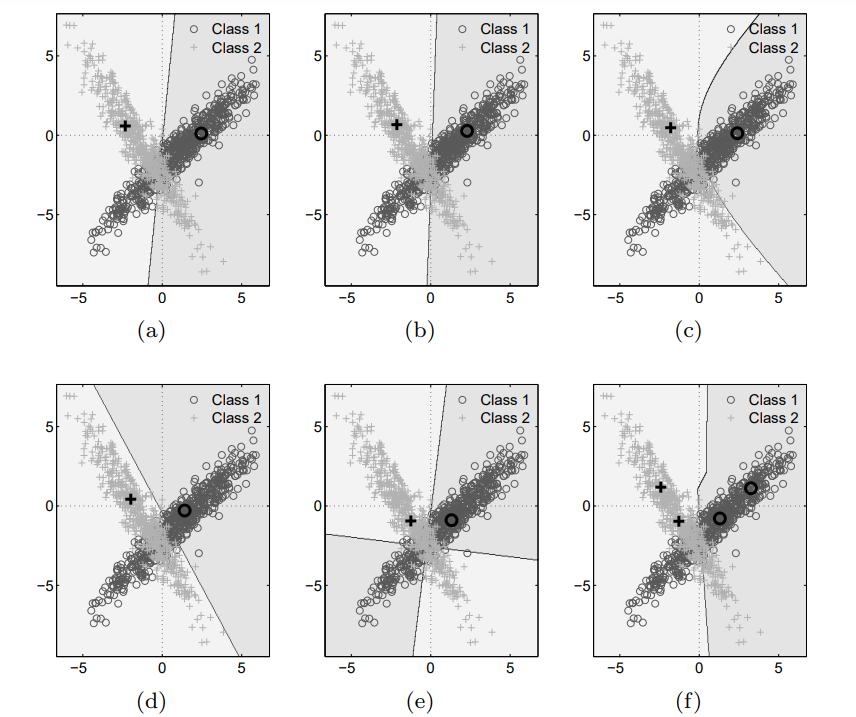

a) GLVQ

b) GRLVQ

c) LGRLVQ

d) GMLVQ

e) LGMLVQ

f) GLVQ using two prototypes per class

In [ ]:
# if we wanted to get specific accuracies (although it's easy to see which model is better)

# X, y = data.tensors
# preds = predict_class(X, model)
# (y == preds).float().mean()

## Test 2: Breast cancer dataset

Will the model work with real data? The breast cancer dataset serves as a critical benchmark for assessing the performance of LVQ in a practical and medically relevant setting. The dataset comprises 30 numeric features derived from diagnostic measurements, such as cell characteristics and histological attributes, to classify tumors into malignant or benign categories. This binary classification task presents a rigorous test for LVQ’s capability to not only classify instances accurately but also to discern meaningful patterns in the data.

In [ ]:
cancer_data = load_breast_cancer()
# data = TensorDataset(torch.from_numpy(cancer_data.data).float(), torch.from_numpy(cancer_data.target))
# load the data
cancer_data = load_breast_cancer()
X = torch.from_numpy(cancer_data.data).float()
y = torch.from_numpy(cancer_data.target)

# split the data
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=8, shuffle=True)
test_data = TensorDataset(Xtest, ytest)
test_dl = DataLoader(test_data, batch_size=8, shuffle=False)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

model = LVQ('gmlvq', train_data, [1, 1])
loss_function = GLVQLoss(nn.ReLU()) # instead of the identity, we are now using ReLU
optimizer = torch.optim.SGD([
      {'params': model.W, 'lr': 0.01},
      {'params': model.Q, 'lr': 0.01}
  ])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
train_lvq(model, train_dl, 20, loss_function, optimizer, scheduler)

acc = lvq_accuracy(model, Xtest, ytest)

Training data size: torch.Size([455, 30])
Test data size: 114
Epoch 1/20, Loss: 0.06907271848697412
Epoch 2/20, Loss: 0.06933808950053756
Epoch 3/20, Loss: 0.06907180393637534
Epoch 4/20, Loss: 0.06922253959795885
Epoch 5/20, Loss: 0.06929637032577343
Epoch 6/20, Loss: 0.069071803601426
Epoch 7/20, Loss: 0.06933809014592777
Epoch 8/20, Loss: 0.06964166534312985
Epoch 9/20, Loss: 0.06938204055717379
Epoch 10/20, Loss: 0.06907180441837561
Epoch 11/20, Loss: 0.06963665241767701
Epoch 12/20, Loss: 0.06972619392010465
Epoch 13/20, Loss: 0.06934338893022454
Epoch 14/20, Loss: 0.06907180481868093
Epoch 15/20, Loss: 0.06907180331549362
Epoch 16/20, Loss: 0.06927331727357548
Epoch 17/20, Loss: 0.06937273282132912
Epoch 18/20, Loss: 0.06916418838265695
Epoch 19/20, Loss: 0.06937924747992504
Epoch 20/20, Loss: 0.06907180360959549
Accuracy: 0.9386


In [ ]:
# comparison with other algorithm
def compare_with(clf_tup, Xtrain, ytrain, Xtest, ytest):
  name, clf = clf_tup
  cv_results = cross_validate(clf, Xtrain, ytrain, cv=5, scoring='accuracy')
  test_results = clf.fit(Xtrain, ytrain).score(Xtest, ytest)
  print(f'Average cross validation accuracy {name}: {cv_results["test_score"].mean():.4f}')
  print(f'Test accuracy {name}: {test_results:.4f}')

  return None

compare_with(('SVM', SVC(kernel='linear')),Xtrain, ytrain, Xtest, ytest)

Average cross validation accuracy SVM: 0.9516
Test accuracy SVM: 0.9649


## Test 3: Iris dataset

Will the model work well with more than 2 classes? LVQ can be naturally extended to a multiclass setting, let's see if that also happens with out implementation. We'll use the famous Iris dataset for that purpose

In [ ]:
iris_data = load_iris()
X = torch.from_numpy(iris_data.data).float()
y = torch.from_numpy(iris_data.target)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=16, shuffle=True)
test_data = TensorDataset(Xtest, ytest)
test_dl = DataLoader(test_data, batch_size=16, shuffle=False)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

model = LVQ('grlvq', train_data, [1, 1, 1]) # here is the little change to incorporate more than two classes
loss_function = GLVQLoss(nn.Identity())
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
train_lvq(model, train_dl, 10, loss_function, optimizer)

acc = lvq_accuracy(model, Xtest, ytest)

Training data size: torch.Size([120, 4])
Test data size: 30
Epoch 1/10, Loss: -0.6931396275758743
Epoch 2/10, Loss: -0.7052224278450012
Epoch 3/10, Loss: -0.6970410794019699
Epoch 4/10, Loss: -0.7202270850539207
Epoch 5/10, Loss: -0.7116026654839516
Epoch 6/10, Loss: -0.7305767238140106
Epoch 7/10, Loss: -0.7281564772129059
Epoch 8/10, Loss: -0.7446763068437576
Epoch 9/10, Loss: -0.7445089370012283
Epoch 10/10, Loss: -0.7374046295881271
Accuracy: 1.0000


In [ ]:
# comparison with other algorithm
compare_with(('LDA', LDA()), Xtrain, ytrain, Xtest, ytest)

Average cross validation accuracy LDA: 0.9750
Test accuracy LDA: 1.0000


## Test 4: Apple quality dataset

This [dataset](https://www.kaggle.com/datasets/nelgiriyewithana/apple-quality) is not widely known, but I've chosen it because it illustrates problems where prototype learning, and LVQ in particular, can be highly beneficial. The dataset contains a few thousand apples, and the goal is to determine their quality (good vs. bad) based on numerical features such as size, weight, sweetness... Most classifiers can predict an apple's quality given its characteristics, but they only provide this binary classification. In contrast, LVQ not only learns to distinguish between good and bad apples but also identifies prototypes for each quality category. From a company's perspective, these prototypes can serve as valuable benchmarks or objectives.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks/LVQ

/content/drive/MyDrive/Colab_Notebooks/LVQ


In [ ]:
df = pd.read_csv('apple_quality.csv', skipfooter=1)
df.drop(columns=['A_id'], inplace=True) # remove identifier
df['Quality_ohe'] = (df['Quality'] == 'good').astype(float) # one hot encoding

Xtrain, Xtest, ytrain, ytest = train_test_split(df.drop(['Quality', 'Quality_ohe'], axis=1),
                                                df['Quality_ohe'],
                                                test_size=0.2,
                                                random_state=42)

Xtrain = torch.from_numpy(Xtrain.values).float()
ytrain = torch.from_numpy(ytrain.values)
train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=8, shuffle=True)

Xtest = torch.from_numpy(Xtest.values).float()
ytest = torch.from_numpy(ytest.values)
test_data = TensorDataset(Xtest, ytest)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

model = LVQ('lgmlvq', train_data, [1, 1])
loss_function = GLVQLoss(nn.Sigmoid())

# check this out, we are not forced to always use vanilla gradient descent!
optimizer = torch.optim.RMSprop([
    {'params': model.W, 'lr': 0.01},
    {'params': model.Q, 'lr': 0.001}
])
train_lvq(model, train_dl, 20, loss_function, optimizer)

acc = lvq_accuracy(model, Xtest, ytest)

<ipython-input-163-7a7fa0cf3376>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  df = pd.read_csv('apple_quality.csv', skipfooter=1)


Training data size: torch.Size([3200, 7])
Test data size: 800
Epoch 1/20, Loss: 0.41311512246727944
Epoch 2/20, Loss: 0.3892313340306282
Epoch 3/20, Loss: 0.3831415768712759
Epoch 4/20, Loss: 0.380681771337986
Epoch 5/20, Loss: 0.37970644123852254
Epoch 6/20, Loss: 0.3793743672966957
Epoch 7/20, Loss: 0.3792620095610619
Epoch 8/20, Loss: 0.37888673596084116
Epoch 9/20, Loss: 0.37866863548755647
Epoch 10/20, Loss: 0.3791529332101345
Epoch 11/20, Loss: 0.3789173597842455
Epoch 12/20, Loss: 0.37850620880723
Epoch 13/20, Loss: 0.3788585527986288
Epoch 14/20, Loss: 0.37890897393226625
Epoch 15/20, Loss: 0.379001991674304
Epoch 16/20, Loss: 0.37886993169784544
Epoch 17/20, Loss: 0.37914809457957743
Epoch 18/20, Loss: 0.37870568357408047
Epoch 19/20, Loss: 0.37876565717160704
Epoch 20/20, Loss: 0.3789332339167595
Accuracy: 0.8275


In [ ]:
compare_with(('SVM', SVC(kernel='rbf')), Xtrain, ytrain, Xtest, ytest)

Average cross validation accuracy SVM: 0.8822
Test accuracy SVM: 0.9075


## Test 5: digits dataset (8 × 8 images)

How does the model work with images? Do we get useful prototypes? By applying prototype learning methods such as Learning Vector Quantization (LVQ) to this dataset, we can investigate if the model not only achieves high accuracy but also generates prototypes that offer clear, interpretable representations of each digit. These prototypes could be beneficial for understanding how the model perceives and distinguishes between different digits, providing deeper insights into the image classification process. ([guide](https://scikit-learn.org/stable/datasets/toy_dataset.html#digits-dataset))

In [ ]:
digits_data = load_digits()

X = torch.from_numpy(digits_data.data).float()
y = torch.from_numpy(digits_data.target)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=8, shuffle=True)
test_data = TensorDataset(Xtest, ytest)
test_dl = DataLoader(test_data, batch_size=8, shuffle=False)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

device = 'cpu'
prototypes_per_class = [1]*y.unique().numel()
# prototypes_per_class = [1, 1, 1, 1, 1, 1, 1, 1, 1, 2] # alternative if we want to have two prototypes for "9"

# we choose plain glvq because prototypes are more "understandable", as
# you will see later.
# we also force a naive initialization (prototypes are initialized as the global mean + normal noise)
# instead of using class means to see the evolution in the prototypes
model = LVQ('glvq', train_data, prototypes_per_class, naive_init=True)
loss_function = GLVQLoss(nn.Sigmoid())

# we are getting the initial prototypes for visualization purposes (see later)
initial_W = [model.W[i].detach().clone() for i in range(len(model.W))]
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

train_lvq(model, train_dl, 40, loss_function, optimizer, scheduler=None, verbose=False)

acc = lvq_accuracy(model, Xtest, ytest)

Training data size: torch.Size([1437, 64])
Test data size: 360
Accuracy: 0.9194


In [ ]:
compare_with(('SVM', SVC(kernel='linear')), Xtrain, ytrain, Xtest, ytest)

Average cross validation accuracy SVM: 0.9708
Test accuracy SVM: 0.9778


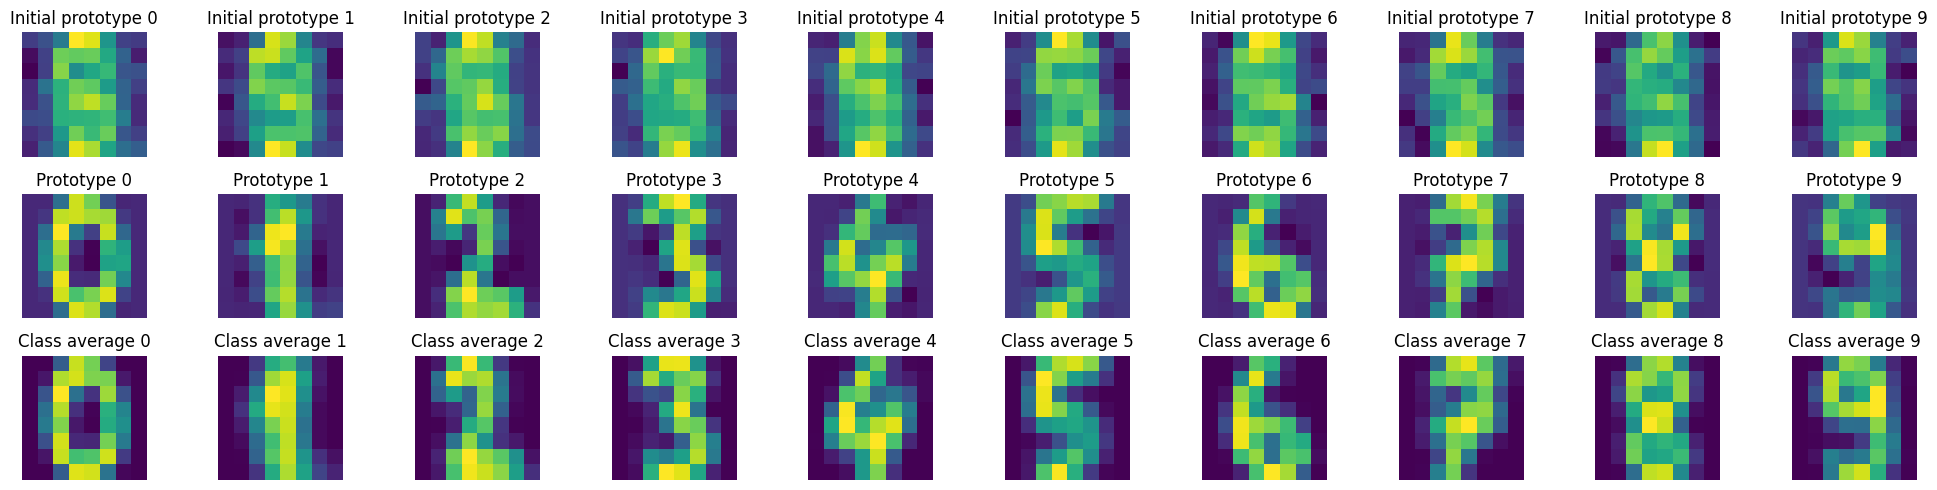

In [ ]:
def plot_img_prototypes(model, initial_W, X, y, img_size, out_name):
  """
  Plots and saves the initial prototypes, learned prototypes, and real class averages
  as images for each class after training.

  Args:
      model (LVQ): Trained LVQ model containing learned prototypes.
      X (torch.Tensor): Input data (images), tensor of shape (n_samples, n_features).
      y (torch.Tensor): Labels associated with the input data, tensor of shape (n_samples).
      img_size (int): Size of the square images (height and width).
      out_name (str): Name of the output file to save the plot (without extension).

  Returns:
      None: The function saves a PNG file with the plot and displays it.

  Example:
      >>> plot_img_prototypes(trained_model, X, y, 28, 'prototypes_plot')

  Functionality:
  - First row: Displays the initial prototypes (before learning).
  - Second row: Displays the learned prototypes (after training).
  - Third row: Displays the real average images of each class from the dataset.
  - The function outputs a `.png` file with the generated plots.
  """

  p = model.n_prototypes
  fig, axes = plt.subplots(3, p, figsize=(20, 5))

  for i in range(p):

      initial_prototype = initial_W[i].reshape(img_size, img_size).numpy()
      ax0 = axes[0, i]
      ax0.imshow(initial_prototype) # , cmap='gray'
      ax0.axis('off')
      ax0.set_title(f'Initial prototype {i}')

      # prototype after learning
      prototype = model.W[i].detach().reshape(img_size, img_size).numpy()
      ax1 = axes[1, i]
      ax1.imshow(prototype) # , cmap='gray'
      ax1.axis('off')
      ax1.set_title(f'Prototype {i}')

      # Compute and show real average of each class
      real_avg = X[y == i].mean(dim=0).reshape(img_size, img_size).numpy()
      ax2 = axes[2, i]
      ax2.imshow(real_avg) # , cmap='gray'
      ax2.axis('off')
      ax2.set_title(f'Class average {i}')

  plt.tight_layout()
  plt.savefig(f'{out_name}.png', dpi=300, bbox_inches='tight')
  plt.show()

  return None

plot_img_prototypes(model, initial_W, X, y, 8, 'lvq_digits')

See that? Our "machine" began with a vague understanding of digits, but as it processed numerous examples from the dataset, it developed clear representations (prototypes) for each digit. Whenever it encounters a new digit, it retrieves these prototypes from memory and compares the new digit to them. By learning what digits like "2" or "5" typically look like, the machine can accurately classify new digits most of the time.

Despite that, it was a bit disappointing to see the significant accuracy gap compared to the SVM alternative. However, it’s important to consider that we used a simpler LVQ variant with a naive initialization, which can make learning more challenging. To address this, we’ll now fit a more advanced LVQ model, so don’t lose faith in LVQ just yet.

In [ ]:
model = LVQ('lgmlvq', train_data, prototypes_per_class, naive_init=False)
loss_function = GLVQLoss(nn.Sigmoid())

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_lvq(model, train_dl, 40, loss_function, optimizer, scheduler=None, verbose=False)

acc = lvq_accuracy(model, Xtest, ytest)

Accuracy: 0.9806


Test 6: MNIST dataset

Will the model work with high dimensional data and medium/large datasets? The model (at least some of the versions) work well with well with small datasets and less than 100 features, but in many situations we would need to deal with big datasets with way more features. Theoretical analysis anticipates that GMLVQ models are not a reasonable option in this cases because "computational costs [which] scale quadratically with the data dimensionality. Thus, quadratic instead of linear effort can be observed in every update step. Obviously, the method becomes computationally infeasible for very high dimensional data, i.e. 50 or more dimensions" (Schneider et al., 2009). In those situations, what can be done is adapt the matrix by "enforcing e.g. a limited rank of the matrix". This means that ${\bf Q}$ is not $p \times p$, but $p \times r$, with $r \ll p$ ($p$ is the number of features).

Let's try what happens with the MNIST dataset when using both GMLVQ alternatives

In [ ]:
digits_train = MNIST(root='./data', train=True, download=True, transform=None)
Xtrain = digits_train.data.flatten(start_dim=1, end_dim=2).float()
ytrain = digits_train.targets
train_data = TensorDataset(Xtrain, ytrain)
train_dl = DataLoader(train_data, batch_size=16, shuffle=True)

digits_test = MNIST(root='./data', train=False, download=True, transform=None)
Xtest = digits_test.data.flatten(start_dim=1, end_dim=2).float()
ytest = digits_test.targets
test_data = TensorDataset(Xtrain, ytrain)

print('Training data size:', Xtrain.shape)
print('Test data size:', Xtest.shape[0])

device = 'cpu'
prototypes_per_class = [1]*ytrain.unique().numel()

loss_function = GLVQLoss(nn.ReLU())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 35764975.65it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1342238.63it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9776548.63it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 1898030.17it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training data size: torch.Size([60000, 784])
Test data size: 10000


In [ ]:
# full rank model: Q matrix is 784 x 784!
model_full = LVQ('gmlvq', train_data, prototypes_per_class, naive_init=False)
optimizer = torch.optim.Adam([
    {'params': model_full.W, 'lr': 0.01},
    {'params': model_full.Q, 'lr': 0.001}
])

start = time()
train_lvq(model_full, train_dl, 10, loss_function, optimizer, scheduler=None, verbose=True)
end = time()
print('Training time full rank model:', (end - start)/60)
acc = lvq_accuracy(model_full, Xtest, ytest)

Epoch 1/10, Loss: 0.060383220231555366
Epoch 2/10, Loss: 0.05668102145648154
Epoch 3/10, Loss: 0.05341387030132755
Epoch 4/10, Loss: 0.05151383971192797
Epoch 5/10, Loss: 0.04835201078282426
Epoch 6/10, Loss: 0.04789026859532654
Epoch 7/10, Loss: 0.04565780558801198
Epoch 8/10, Loss: 0.04361076997780862
Epoch 9/10, Loss: 0.04217445535974693
Epoch 10/10, Loss: 0.04022293095990996
Training time full rank model: 30.693514502048494
Accuracy: 0.7034


In [ ]:
# limited rank model: Q matrix is just 784 x 20
model_lim = LVQ('gmlvq', train_data, prototypes_per_class, naive_init=False, Q_rank=20)
optimizer = torch.optim.Adam([
    {'params': model_lim.W, 'lr': 0.01},
    {'params': model_lim.Q, 'lr': 0.001}
])

start = time()
train_lvq(model_lim, train_dl, 10, loss_function, optimizer, scheduler=None, verbose=True)
end = time()
print('Training time limited rank model:', (end - start)/60)
acc = lvq_accuracy(model_lim, Xtest, ytest)

Epoch 1/10, Loss: 0.024052356710682624
Epoch 2/10, Loss: 0.019638755955913377
Epoch 3/10, Loss: 0.01786137058915677
Epoch 4/10, Loss: 0.01705550442239619
Epoch 5/10, Loss: 0.016361485048631826
Epoch 6/10, Loss: 0.01622419576663912
Epoch 7/10, Loss: 0.015414749924490859
Epoch 8/10, Loss: 0.014833231707938103
Epoch 9/10, Loss: 0.014462069061403841
Epoch 10/10, Loss: 0.01393588647092062
Training time limited rank model: 7.635886398951213
Accuracy: 0.8059


That's impressive. Although neither of the models had fully converged yet and both still have room for improvement, we can draw some conclusions. Having fewer parameters not only drastically reduces computation time but also improves performance or, at the very least, increases the convergence rate.

Unfortunately, the limited-rank model is still somewhat slow and likely cannot compete with neural networks in terms of speed and scalability.

In [ ]:
compare_with(
    ('MLP', MLPClassifier(hidden_layer_sizes=(20,), activation='relu', solver='adam')),
    Xtrain, ytrain, Xtest, ytest
)

Average cross validation accuracy MLP: 0.9208
Test accuracy MLP: 0.9343


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
